In [1]:
import csv
import os
#from textblob import TextBlob
import nltk
#import spacy
#nlp = spacy.load("en")

#import Valence
#Valence.download_depechemood()

import sklearn

from nltk.corpus import stopwords
STOPWORDS = list(set(stopwords.words('english')))
punctuations = ['\n', "\'", '\"', ',', '.', ')', '(', "]", "[", '-']+[str(i) for i in range(10)]

import numpy as np
from sklearn.decomposition import TruncatedSVD

from gensim.models import Word2Vec

classes = ["business", "entertainment", "politics", "sport", "tech"]
lemma = nltk.stem.WordNetLemmatizer()
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
#reading dataset
data = []
for c in classes:
    for File in os.listdir("data/"+c):
        s = "".join(i if i not in punctuations else ' ' for i in open("data/"+c+'/'+File).read())
        s = " ".join(lemma.lemmatize(i) for i in s.split() if i not in STOPWORDS)
        data.append(s)
        
print("total data length : ", len(data))

total data length :  1500


In [3]:
maxx, minn = 0, 100000
for i in data:
    maxx = max(maxx, len(i.split()))
    minn = min(minn, len(i.split()))
    
print("max and min number of words across documents : ", maxx, minn)

max and min number of words across documents :  2437 69


In [4]:
def mod_kmeans(ctrs, X):
    ctrs = 300 if ctrs>300 else ctrs
    maxx, maxx_ctr, n_labels = 0, 0, []
    for ctr in range(ctrs):
        init_ctrs = np.array([X[0+ctr], X[300+ctr], X[600+ctr], X[900+ctr], X[1200+ctr]])
        kmeans = KMeans(n_clusters=5, n_init=1, init=init_ctrs).fit(X)
        actual_ctrs = np.array([cc for cc, _ in enumerate(classes) for _ in range(300)])
        accuracy = np.sum(kmeans.labels_ == actual_ctrs) / 1500
        
        if accuracy > maxx:
            maxx = accuracy
            maxx_ctr = ctr
            n_labels = kmeans.labels_
    
    return maxx_ctr, maxx, n_labels

In [5]:
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(stop_words=STOPWORDS, max_features=200)

In [6]:
#tf-idf conversion of train data
tfidf_matrix = vectorizer.fit_transform(data)
X = tfidf_matrix.todense().tolist()
#to_minus = len(X[0])     #padding the data(pre-processing step)
#for dd, d in enumerate(X):
#    X[dd] += [0] * (len_corpus-to_minus)
print("shape of tf-ifd : ", len(X), len(X[0]))

shape of tf-ifd :  1500 200


In [7]:
n_iters = 10
maxx_ctr, maxx, n_labels = mod_kmeans(n_iters, X)
print("maxx accuracy achieved with initial centre {} accuracy : {}".format(maxx_ctr, maxx))

maxx accuracy achieved with initial centre 1 accuracy : 0.8673333333333333


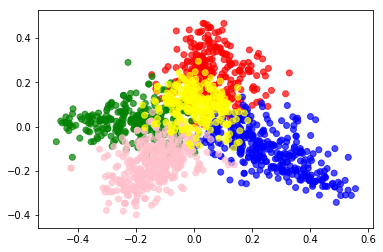

In [8]:
pca = PCA(n_components=2).fit_transform(X)
plot = []
markers = ['o', 'x', '+', '<', 'd']
colors = ['red', 'green', 'blue', 'pink', 'yellow']

for cls in range(5):
    for ii, i in enumerate(n_labels):
        if i == cls:
            plot.append([pca[ii][0], pca[ii][1], colors[cls], markers[cls]])
    
plot = list(zip(*plot))
plt.scatter(plot[0], plot[1], c=plot[2], alpha=0.7)
plt.plot()
plt.savefig("TF-IDF_kmeans.png", dpi=300)

In [9]:
clf = sklearn.svm.LinearSVC()
clf.fit(X, [c for c in classes for _ in range(300)])
print("accuracy : ", clf.score(X, [c for c in classes for _ in range(300)]))

accuracy :  0.982


/home/manjunath/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


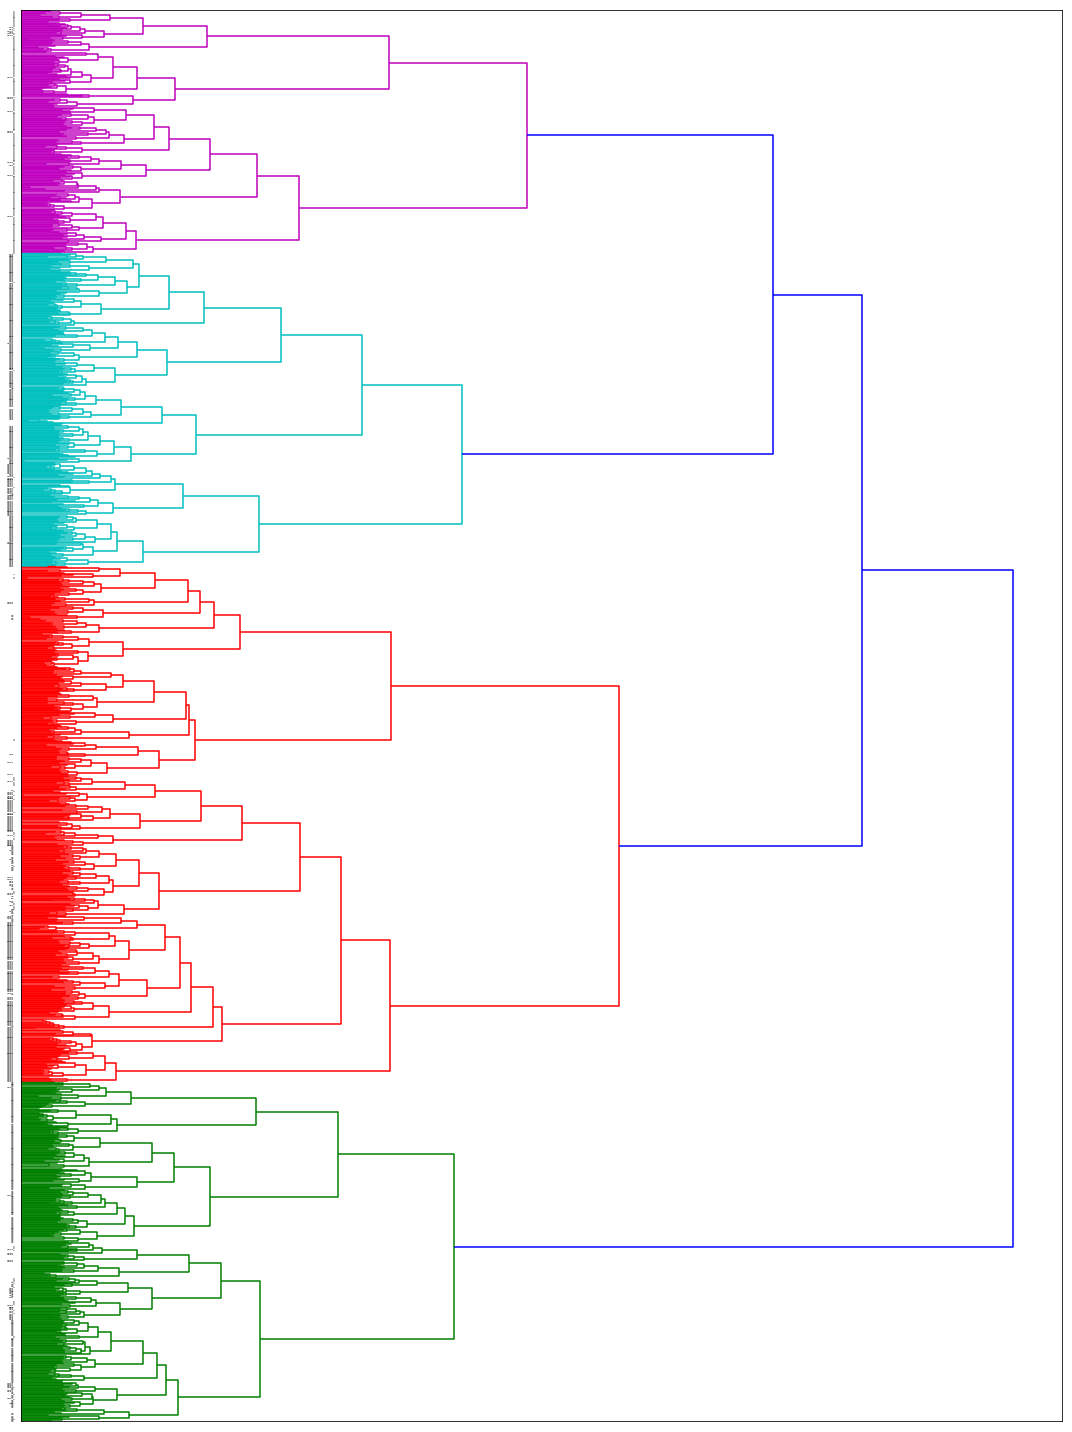

In [10]:
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

dist = 1 - cosine_similarity(tfidf_matrix)
linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=["-"*cc for cc,_ in enumerate(classes) for _ in range(300)])

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('TF-IDF_ward_clusters.png', dpi=300) #save figure as ward_clusters

In [11]:
from sklearn.cluster import DBSCAN
import numpy as np

for e in np.arange(0.5, 1.5, 0.01):
    clustering = DBSCAN(eps=e, min_samples=100, algorithm="brute").fit(X)
    actual_ctrs = np.array([cc for cc, _ in enumerate(classes) for _ in range(300)])
    #print(len(set(clustering.labels_)))
    labels = clustering.labels_
    core_samples = np.zeros_like(actual_ctrs, dtype = int)
    core_samples[clustering.core_sample_indices_] = True
    accuracy = np.sum(clustering.labels_ == actual_ctrs) / 1500
    print(accuracy, e)

0.0 0.5
0.0 0.51
0.0 0.52
0.0 0.53
0.0 0.54
0.0 0.55
0.0 0.56
0.0 0.5700000000000001
0.0 0.5800000000000001
0.0 0.5900000000000001
0.0 0.6000000000000001
0.0 0.6100000000000001
0.0 0.6200000000000001
0.0 0.6300000000000001
0.0 0.6400000000000001
0.0 0.6500000000000001
0.0 0.6600000000000001
0.0 0.6700000000000002
0.0 0.6800000000000002
0.0 0.6900000000000002
0.0 0.7000000000000002
0.0 0.7100000000000002
0.0 0.7200000000000002
0.0 0.7300000000000002
0.0 0.7400000000000002
0.0 0.7500000000000002
0.0 0.7600000000000002
0.0 0.7700000000000002
0.0 0.7800000000000002
0.0 0.7900000000000003
0.0 0.8000000000000003
0.0 0.8100000000000003
0.0 0.8200000000000003
0.0 0.8300000000000003
0.0 0.8400000000000003
0.0 0.8500000000000003
0.0 0.8600000000000003
0.0 0.8700000000000003
0.0 0.8800000000000003
0.0 0.8900000000000003
0.0 0.9000000000000004
0.0 0.9100000000000004
0.0 0.9200000000000004
0.0 0.9300000000000004
0.0 0.9400000000000004
0.0 0.9500000000000004
0.0 0.9600000000000004
0.0 0.970000000000

In [12]:
#preparing the word2vec model
dim = 200
model = Word2Vec([i.split() for i in data], min_count=1, size=dim)

In [13]:
#feature extraction
X = []
for i in data:
    temp, c = [], 0
    for word in i.split():
        c += 1
        temp.append(model.wv.__getitem__(word).tolist())
    X.append([i/c for i in [sum(x) for x in zip(*temp)]])

print("features shape : ", len(X), len(X[0]))

features shape :  1500 200


In [14]:
n_iters = 10
maxx_ctr, maxx, n_labels = mod_kmeans(n_iters, X)
print("maxx accuracy achieved with initial centre {} accuracy : {}".format(maxx_ctr, maxx))

maxx accuracy achieved with initial centre 4 accuracy : 0.4066666666666667


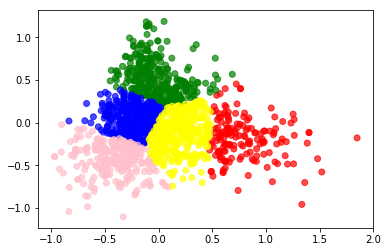

In [15]:
pca = PCA(n_components=2).fit_transform(X)
plot = []
markers = ['o', 'x', '+', '<', 'd']
colors = ['red', 'green', 'blue', 'pink', 'yellow']

for cls in range(5):
    for ii, i in enumerate(n_labels):
        if i == cls:
            plot.append([pca[ii][0], pca[ii][1], colors[cls], markers[cls]])
    
plot = list(zip(*plot))
plt.scatter(plot[0], plot[1], c=plot[2], alpha=0.7)
plt.plot()
plt.savefig("Word2Vec_kmeans.png", dpi=300)

In [16]:
clf = sklearn.svm.LinearSVC()
clf.fit(X, [c for c in classes for _ in range(300)])
print("accuracy : ", clf.score(X, [c for c in classes for _ in range(300)]))

accuracy :  0.6706666666666666


/home/manjunath/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


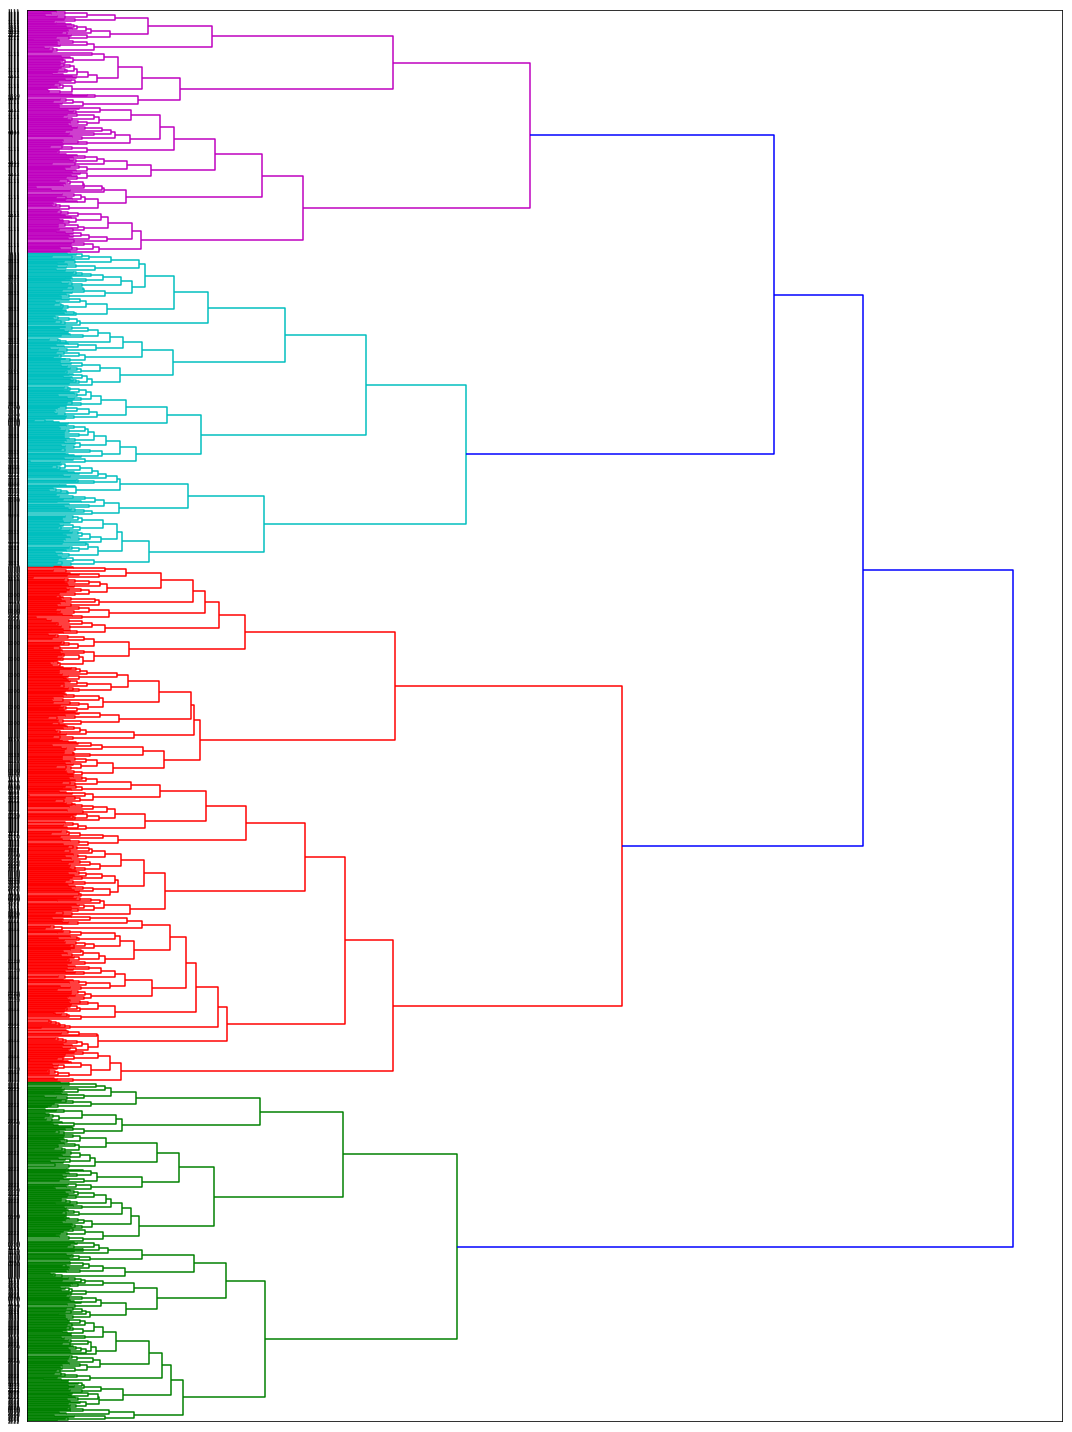

In [17]:
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

dist = 1 - cosine_similarity(tfidf_matrix)
linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=[str(cc)*4 for cc,_ in enumerate(classes) for _ in range(300)])

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('Word2Vec_ward_clusters.png', dpi=300) #save figure as ward_clusters

In [18]:
from sklearn.cluster import DBSCAN
import numpy as np

for e in np.arange(0.5, 1.5, 0.01):
    clustering = DBSCAN(eps=1.2, min_samples=e, algorithm="brute").fit(X)
    actual_ctrs = np.array([cc for cc, _ in enumerate(classes) for _ in range(300)])
    #print(len(set(clustering.labels_)))
    labels = clustering.labels_
    core_samples = np.zeros_like(actual_ctrs, dtype = int)
    core_samples[clustering.core_sample_indices_] = True
    accuracy = np.sum(clustering.labels_ == actual_ctrs) / 1500
    print("for eps : {}, acheived accuracy is : {}".format(accuracy, e))

for eps : 0.2, acheived accuracy is : 0.5
for eps : 0.2, acheived accuracy is : 0.51
for eps : 0.2, acheived accuracy is : 0.52
for eps : 0.2, acheived accuracy is : 0.53
for eps : 0.2, acheived accuracy is : 0.54
for eps : 0.2, acheived accuracy is : 0.55
for eps : 0.2, acheived accuracy is : 0.56
for eps : 0.2, acheived accuracy is : 0.5700000000000001
for eps : 0.2, acheived accuracy is : 0.5800000000000001
for eps : 0.2, acheived accuracy is : 0.5900000000000001
for eps : 0.2, acheived accuracy is : 0.6000000000000001
for eps : 0.2, acheived accuracy is : 0.6100000000000001
for eps : 0.2, acheived accuracy is : 0.6200000000000001
for eps : 0.2, acheived accuracy is : 0.6300000000000001
for eps : 0.2, acheived accuracy is : 0.6400000000000001
for eps : 0.2, acheived accuracy is : 0.6500000000000001
for eps : 0.2, acheived accuracy is : 0.6600000000000001
for eps : 0.2, acheived accuracy is : 0.6700000000000002
for eps : 0.2, acheived accuracy is : 0.6800000000000002
for eps : 0.2, a